# Complex Networks
## Multiplex and Temporal Analysis of the Bitcoin Alpha Trust Network


**Theodoros Lambrou & Alana Zoloeva**

----

### Summary of the network


Bitcoin Alpha social network. This is a signed directed network that captures trust/distrust relationships between users on the Bitcoin Alpha platform. https://snap.stanford.edu/data/soc-sign-bitcoinalpha.html

**Dataset:** The Bitcoin Alpha network represents interactions between users on a Bitcoin trading platform where users can rate each other (positively or negatively) to indicate trust or distrust.

**Key characteristics:**

- Directed network (relationships go from one user to another)
- Signed edges (positive/negative representing trust/distrust)
- Collected from a Bitcoin trading platform called Bitcoin Alpha
- Contains 3,783 nodes (users) and 24,186 edges (ratings)
- Positive edges: 22650 (93.65%) / Negative edges: 1536 (6.35%)
- Timespan: October 2010 to January 2016


### Imports & Setup


In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from networkx.algorithms.community import girvan_newman, modularity
from datetime import datetime
import random
import itertools

sns.set(style="whitegrid")

### Load & Preprocess Dataset
We load the Bitcoin Alpha dataset and convert the timestamps into readable datetime format. We also classify the edge signs into either 'trust' or 'distrust' based on the weight. We kept all edges (no filtering) to preserve full dynamics.

In [3]:
data = pd.read_csv('soc-sign-bitcoinalpha.csv', comment='#', names=["source", "target", "weight", "timestamp"])
data['datetime'] = pd.to_datetime(data['timestamp'], unit='s') 
data['sign'] = data['weight'].apply(lambda x: 'trust' if x > 0 else 'distrust')

### Construct Graph
We then build a directed graph where each edge carries attributes like weight, timestamp, and sign. Directed edges reflect the asymmetry of trust (A can trust B without reciprocity). Edge attributes allow multiplex and temporal analysis.

In [4]:
G = nx.DiGraph()
for _, row in data.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['weight'], timestamp=row['datetime'], sign=row['sign'])

### Visualize Subgraph
To get an intuitive look at the network, we visualize a random subgraph of 700 nodes. Green edges show trust, red show distrust. This gives a sense of structure without overwhelming the plot - visualizing the whole graph would also be very slow.

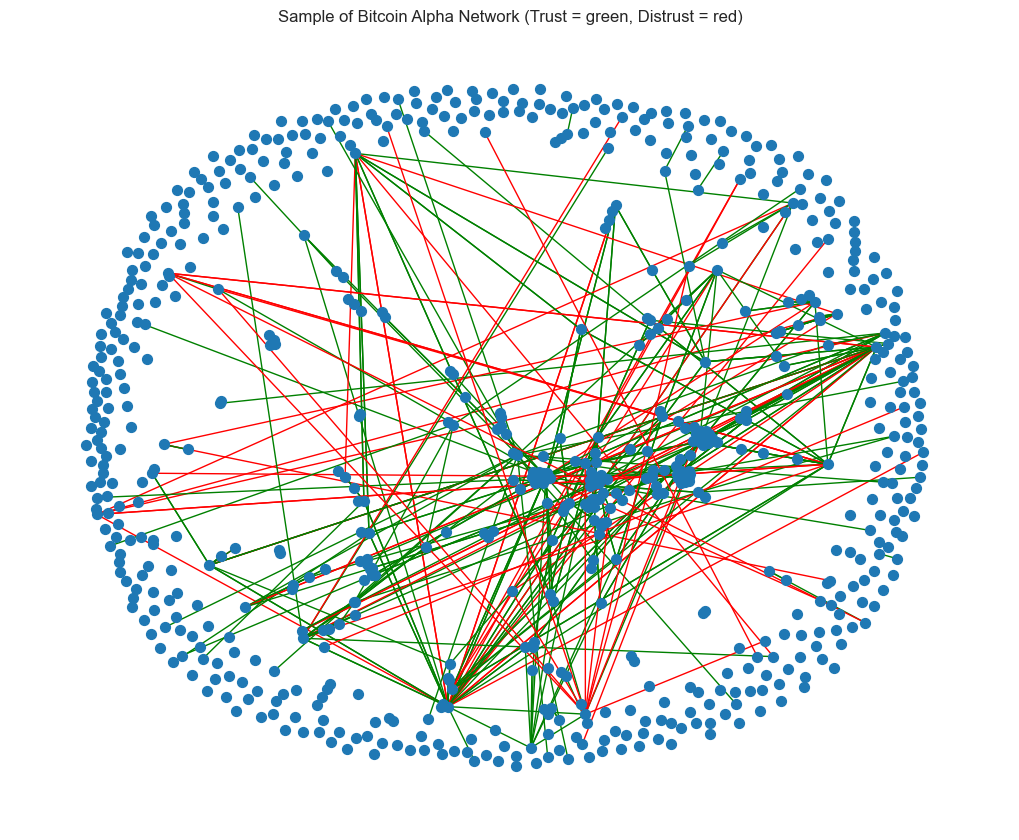

In [11]:
sample_nodes = random.sample(list(G.nodes()), 700)
subG = G.subgraph(sample_nodes).copy()
edge_colors = ['green' if d['sign'] == 'trust' else 'red' for _,_,d in subG.edges(data=True)]
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subG, seed=42)
nx.draw(subG, pos, node_size=50, edge_color=edge_colors, arrows=False, with_labels=False)
plt.title("Sample of Bitcoin Alpha Network (Trust = green, Distrust = red)")
plt.show()

### Structural Analysis
We analyze degree distributions — both in-degree and out-degree — to understand node centrality. We also count the proportion of trust and distrust relationships overall. Distrust links are fewer.. maybe because of social norm enforcement or fear of retaliation.


Nodes: 3783
Edges: 24186


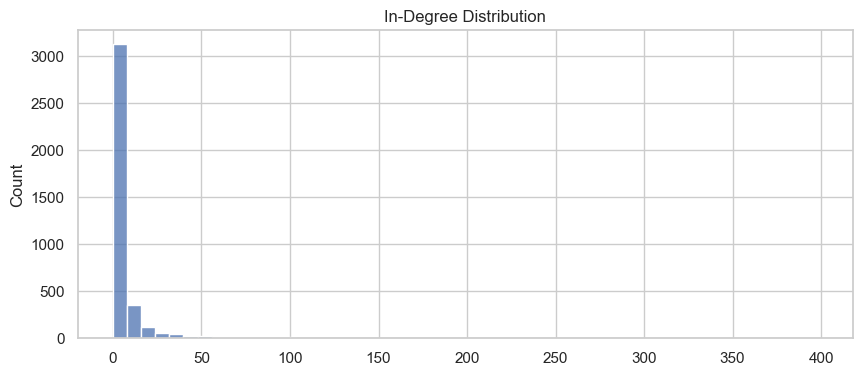

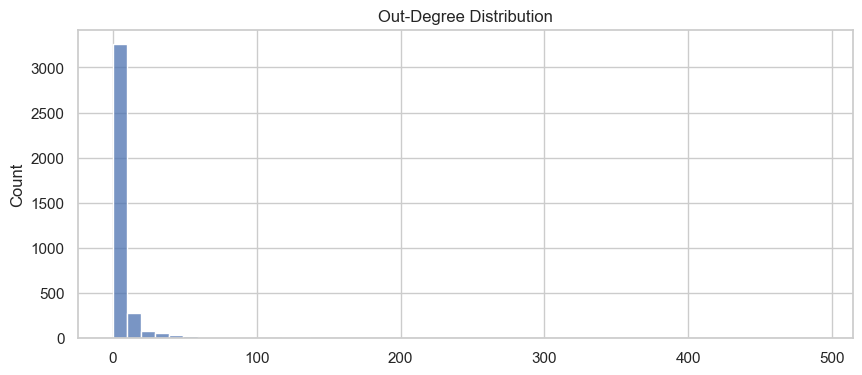

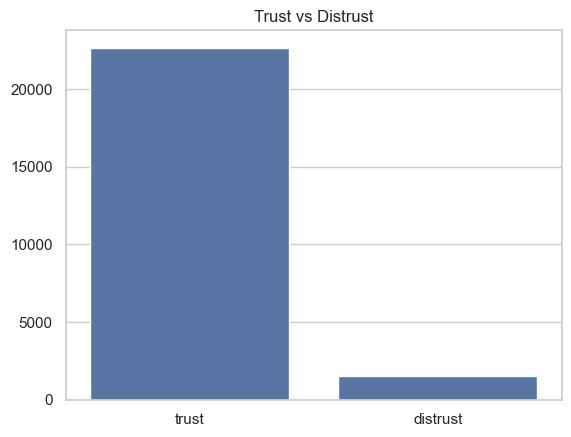

In [8]:
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

plt.figure(figsize=(10,4))
sns.histplot(list(in_degrees.values()), bins=50)
plt.title("In-Degree Distribution")
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(list(out_degrees.values()), bins=50)
plt.title("Out-Degree Distribution")
plt.show()

sign_counts = Counter([d['sign'] for _,_,d in G.edges(data=True)])
sns.barplot(x=list(sign_counts.keys()), y=list(sign_counts.values()))
plt.title("Trust vs Distrust")
plt.show()

Both in-degree and out-degree distributions are highly skewed.
Most users interact with only a few others, while a small number have many incoming or outgoing links.
This suggests a power-law-like structure, where a few nodes dominate interaction, typical of scale-free social networks.

### Reciprocity
This cell measures reciprocity: how often a link from A to B is matched by a link from B to A. It tells us how mutual the relationships are. 

Low reciprocity may suggest hierarchical or expert-based trust structures.

In [9]:
reciprocal_edges = sum(1 for u,v in G.edges() if G.has_edge(v,u))
print("Reciprocity:", reciprocal_edges / G.number_of_edges())

Reciprocity: 0.832051600099231


The reciprocity of the network is around 83%, which is very high.
This suggests that trust relationships in the Bitcoin Alpha network are often mutual... if one user rates another, that user tends to rate them back.

### Community Detection
Using the Girvan–Newman algorithm, we detect communities in the trust-only subgraph. We calculate modularity to evaluate the quality of the community structure. It works well for small to medium graphs.



In [12]:
trust_edges = [(u,v) for u,v,d in G.edges(data=True) if d['sign']=='trust']
G_trust = G.edge_subgraph(trust_edges).copy()
comp = girvan_newman(G_trust)
top_comms = next(comp)
print("Modularity (trust only):", modularity(G_trust, top_comms))

Modularity (trust only): 0.003756056606792501


The modularity score of the trust-only subgraph is approximately 0.0038, which is very low.
This indicates that there’s little to no clear community structure in the trust network — the nodes are not tightly grouped into well-separated clusters.

### Temporal Evolution
We analyze the network over time by plotting monthly activity — basically, how many edges were created per month. This shows us when the network was most active. 

Peak periods could indicate events (e.g., hacks, news) driving user interactions.
Explains how the network grows, not just what it looks like.

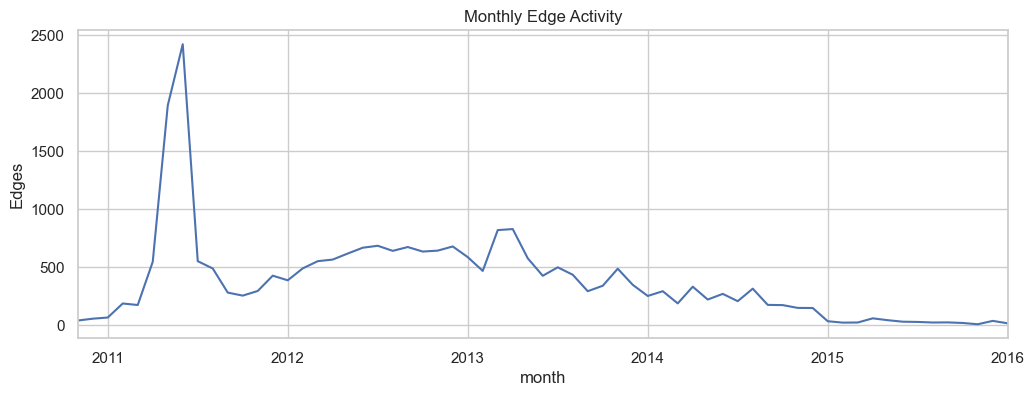

In [13]:
data['month'] = data['datetime'].dt.to_period('M')
monthly_counts = data.groupby('month').size()
monthly_counts.plot(figsize=(12,4), title="Monthly Edge Activity")
plt.ylabel("Edges")
plt.show()

The spike around 2011-2012 might be due to Bitcoin's hightened popularity at the time.

### SI Diffusion Model
Here we simulate a basic Susceptible-Infected model. It models how information or influence could spread through the trust network, starting from a single node.

Infection probability (0.1) is a tunable parameter — increasing it speeds diffusion.

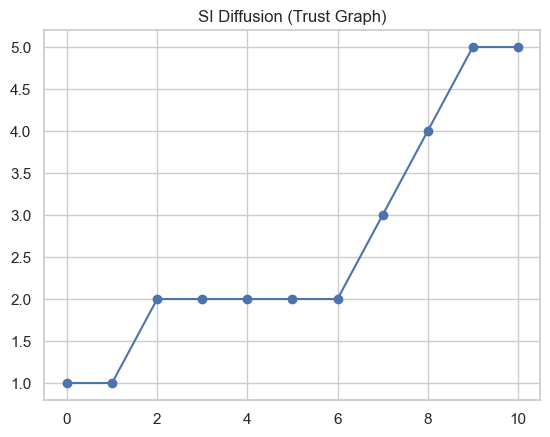

In [14]:
def simulate_SI(G, seed_node, steps=10):
    infected = set([seed_node])
    history = [len(infected)]
    for _ in range(steps):
        new_infected = set()
        for node in infected:
            for nbr in G.successors(node):
                if nbr not in infected and random.random() < 0.1:
                    new_infected.add(nbr)
        infected.update(new_infected)
        history.append(len(infected))
    return history

seed = random.choice(list(G_trust.nodes()))
result = simulate_SI(G_trust, seed)
plt.plot(result, marker='o')
plt.title("SI Diffusion (Trust Graph)")
plt.show()

We simulated the SI model on the trust-only graph, starting from a single seed.
The diffusion is very slow, reaching only 5 infected nodes after 10 steps.
This suggests that either the seed node was poorly connected, or that the trust network has a sparse or fragmented structure with limited reachability.

### Voter Model
This simulates opinion dynamics. Each node updates its opinion based on a random neighbor's opinion. It shows whether the network reaches consensus or stays divided.

If one opinion dominates, then the network likely has a highly connected core or influential nodes.


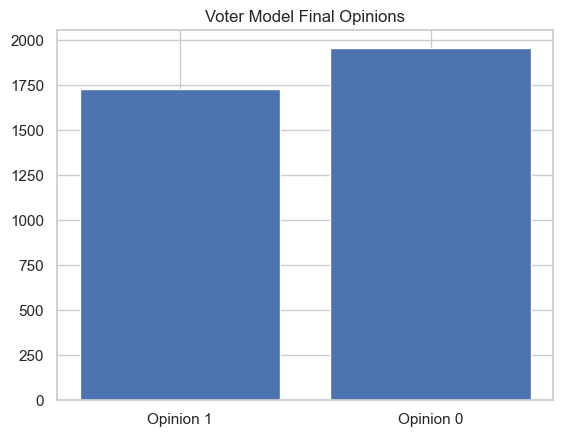

In [15]:
def simulate_voter(G, steps=10):
    opinions = {n: random.choice([0,1]) for n in G.nodes()}
    history = [opinions.copy()]
    for _ in range(steps):
        for node in G.nodes():
            nbrs = list(G.successors(node))
            if nbrs:
                opinions[node] = opinions[random.choice(nbrs)]
        history.append(opinions.copy())
    return history

voter_result = simulate_voter(G_trust, 10)
final_counts = Counter(voter_result[-1].values())
plt.bar(final_counts.keys(), final_counts.values(), tick_label=['Opinion 0','Opinion 1'])
plt.title("Voter Model Final Opinions")
plt.show()

The voter model simulation ended in a near tie between the two opinions.
This means the network didn’t fully converge, likely due to its structure — either because of isolated communities, or weakly connected nodes.
It reflects how diverse opinions can persist in social networks, especially when influence is localized.

### Graph Model Comparisons
We compare our network’s degree distribution to classical models — Erdős–Rényi, Watts–Strogatz, and Barabási–Albert — to see which synthetic model it most resembles.

ER: Random links (benchmark)
WS: Small-world features (clustering + short paths)
BA: Preferential attachment (hubs)

BA typically fits real-world social networks best due to skewed degree distribution.

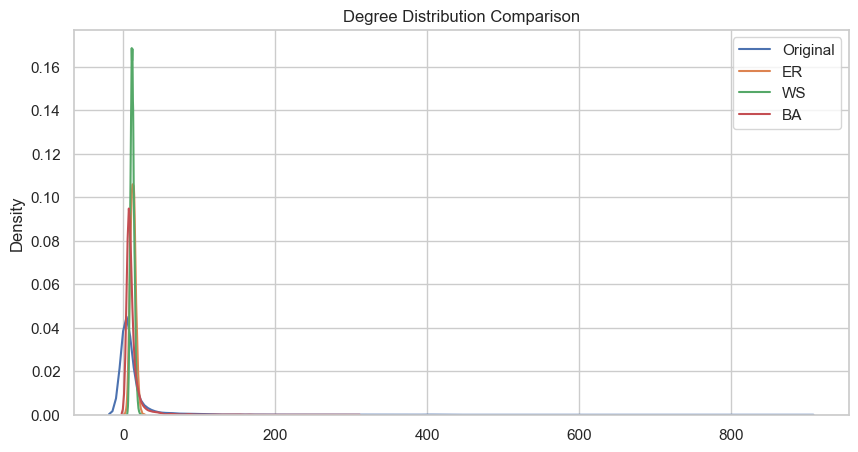

In [16]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
avg_degree = int(2*num_edges/num_nodes)
G_er = nx.gnm_random_graph(num_nodes, num_edges)
G_ws = nx.watts_strogatz_graph(num_nodes, avg_degree, 4)
G_ba = nx.barabasi_albert_graph(num_nodes, max(1, avg_degree//2))

plt.figure(figsize=(10,5))
sns.kdeplot([d for n,d in G.degree()], label='Original')
sns.kdeplot([d for n,d in G_er.degree()], label='ER')
sns.kdeplot([d for n,d in G_ws.degree()], label='WS')
sns.kdeplot([d for n,d in G_ba.degree()], label='BA')
plt.legend()
plt.title("Degree Distribution Comparison")
plt.show()

We compared our network’s degree distribution to classical models.
The real Bitcoin Alpha graph has a heavy-tailed distribution, with a few very high-degree nodes.
This matches the Barabási–Albert model most closely, which reflects preferential attachment — where popular nodes tend to receive more links.

### Multiplex Metrics
Since this is a multiplex network with trust and distrust as layers, we compute the participation coefficient and activity rate. These tell us how involved each node is across layers.

Participation coefficient: how equally a node appears in both trust and distrust layers.

Activity: number of interactions per node.

Multiplexity can reveal whether a node behaves consistently across types of relationships.



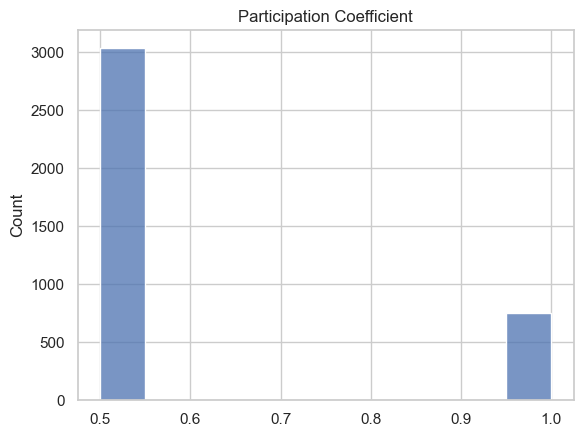

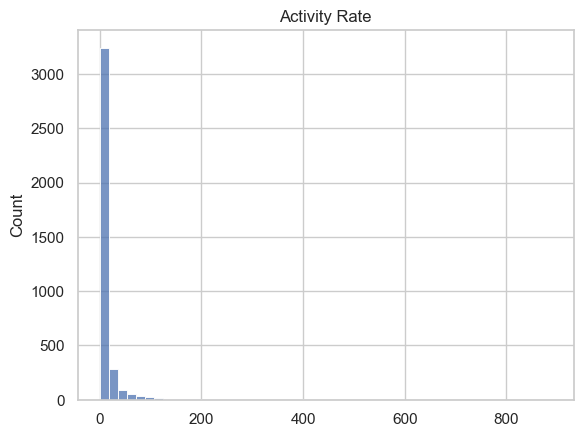

In [17]:
nodes = set(data['source']) | set(data['target'])
participation = defaultdict(set)
activity = defaultdict(int)
for _, row in data.iterrows():
    participation[row['source']].add(row['sign'])
    participation[row['target']].add(row['sign'])
    activity[row['source']] += 1
    activity[row['target']] += 1

p_vals = [len(participation[n])/2 for n in nodes]
a_vals = [activity[n] for n in nodes]

sns.histplot(p_vals, bins=10)
plt.title("Participation Coefficient")
plt.show()

sns.histplot(a_vals, bins=50)
plt.title("Activity Rate")
plt.show()

These plots show how users interact across the two layers — trust and distrust.
Most users only appear in one layer, with a participation coefficient of 0.5, meaning they either trust or distrust others, but not both.

Only a minority engage in both types of relationships.

The activity rate distribution also confirms a power-law structure: a few highly active users dominate the interactions.

### Higher-Order Motif Count

In this final cell, we analyze signed triads — small 3-node patterns — to understand structural balance in the network.
Since checking all possible triads in a network this large would take hours, we sample 5,000,000 random triplets instead, which should be enough to get statistically meaningful results. The total is over 9 billion possible 3-node combinations.



We then classify each triad based on the combination of trust and distrust signs, and count how often each type appears.
The results are plotted in a bar chart, revealing which motifs are most common — for example, balanced triads like +++ tend to dominate.

These are signed triads:

+++: All trust : highly balanced group

++-: Two trust, one distrust : tension

+--: One trust, two distrust : unstable

---: All distrust : structurally negative group

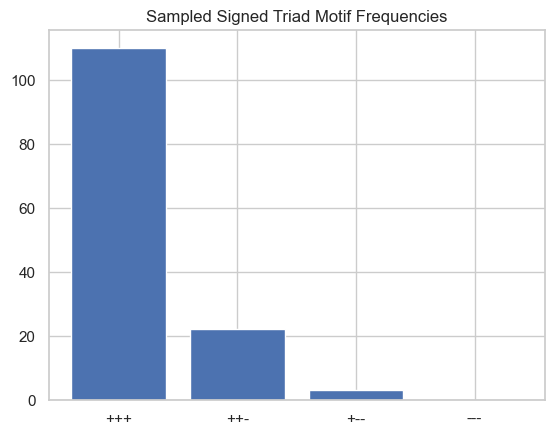

In [8]:
# Count the frequency of signed triads using a sample of random node triplets

triad_types = {'+++': 0, '++-': 0, '+--': 0, '---': 0}
sample_size = 5000000 

nodes_list = list(G.nodes())
for _ in range(sample_size):
    triplet = random.sample(nodes_list, 3)
    sub = G.subgraph(triplet)
    if len(sub.edges()) == 3:
        signs = ''.join(['+' if d['weight'] > 0 else '-' for _, _, d in sub.edges(data=True)])
        if signs in triad_types:
            triad_types[signs] += 1

plt.bar(triad_types.keys(), triad_types.values())
plt.title("Sampled Signed Triad Motif Frequencies")
plt.show()


Although we sampled 5 million node triplets, only a small number formed fully connected triads.

Among those, about 100 were all-trust, which were by far the most common and reflect the dominance of trust in the motif distribution.

Mixed motifs like ++- appear less often, indicating some level of imbalance or tension.

Fully distrust-based groups were almost non-existent.